# Описание проекта:

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

# 1. Подготовка данных

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import time

In [2]:
df = pd.read_csv('/datasets/autos.csv')
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
DateCrawled          354369 non-null object
Price                354369 non-null int64
VehicleType          316879 non-null object
RegistrationYear     354369 non-null int64
Gearbox              334536 non-null object
Power                354369 non-null int64
Model                334664 non-null object
Kilometer            354369 non-null int64
RegistrationMonth    354369 non-null int64
FuelType             321474 non-null object
Brand                354369 non-null object
NotRepaired          283215 non-null object
DateCreated          354369 non-null object
NumberOfPictures     354369 non-null int64
PostalCode           354369 non-null int64
LastSeen             354369 non-null object
dtypes: int64(7), object(9)
memory usage: 43.3+ MB


In [4]:
df = df.drop(['DateCrawled', 'DateCreated', 'LastSeen', 'NumberOfPictures', 'PostalCode'], axis=1)

In [5]:
df.VehicleType.value_counts().sort_values(ascending=False)

sedan          91457
small          79831
wagon          65166
bus            28775
convertible    20203
coupe          16163
suv            11996
other           3288
Name: VehicleType, dtype: int64

In [6]:
df['VehicleType'] = df['VehicleType'].fillna('other')

In [7]:
df.Gearbox.value_counts()

manual    268251
auto       66285
Name: Gearbox, dtype: int64

In [8]:
df['Gearbox'] = df['Gearbox'].fillna('manual')

In [9]:
'other' in df.Model.values

True

In [10]:
df['Model'] = df['Model'].fillna('other')

In [11]:
df.FuelType.value_counts()

petrol      216352
gasoline     98720
lpg           5310
cng            565
hybrid         233
other          204
electric        90
Name: FuelType, dtype: int64

In [12]:
df['FuelType'] = df['FuelType'].fillna('other')

In [13]:
df.NotRepaired.value_counts()

no     247161
yes     36054
Name: NotRepaired, dtype: int64

In [14]:
df['NotRepaired'] = df['NotRepaired'].fillna('no')

(0, 2500)

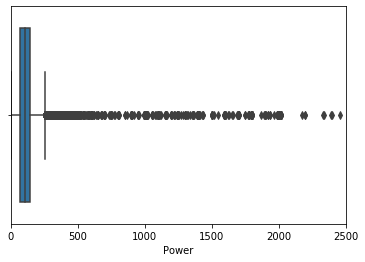

In [15]:
sns.boxplot(df['Power'])
plt.xlim(0, 2500)

In [16]:
df = df[(df['Power'] != 0) & (df['Power'] <= 2500)]

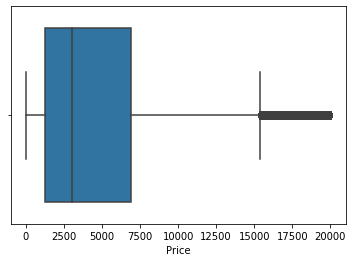

In [17]:
sns.boxplot(df['Price'])

In [18]:
df = df[df['Price'] >= 100]

(1985, 2020)

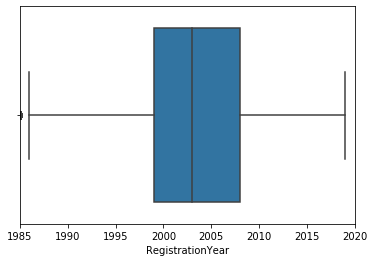

In [19]:
sns.boxplot(df['RegistrationYear'])
plt.xlim(1985, 2020)

In [20]:
df = df[(df['RegistrationYear'] >= 1985) & (df['RegistrationYear'] <= 2020)]

In [21]:
df.duplicated().sum() / len(df) * 100

8.891079805993556

In [22]:
df = df.drop_duplicates().reset_index(drop=True) 

In [23]:
100 - (len(df) / 354369 * 100)

22.28891353363302

### Шаги:
    1.Подключены нужные библиотеки и выведена первичная информация
    2.Удалены ненужные столбцы 'DateCrawled', 'DateCreated', 'LastSeen', 'NumberOfPictures', 'PostalCode'
    3.VehicleType. Пропуски заполнены значениями 'other', которое уже есть в датасете
    4.Gearbox. Пропуски заполнены значением моды, т.е. 'manual'
    5.Model. Пропуски заполнены значениями 'other', которое уже есть в датасете
    6.FuelType. Пропуски заполнены значениями 'other', которое уже есть в датасете
    7.NotRepaired. Пропуски заполнены значением моды, т.е. 'no'
    8.Power. Удалены значения 0 и все значения выше 2500 
    9.Price. Удалены значения ниже 100
    10.RegistrationYear. Удалены значения ниже 1985 и выше 2020
    11.Удалены дубликаты

### Вывод:
    После всех преобразований осталось 88% данных от изначального DataFrame.

# 2. Обучение моделей

In [24]:
def time_score(model, features_train, features_valid, target_train, target_valid):
    start = time.time()
    model.fit(features_train, target_train)
    learn_time = time.time() - start

    start = time.time()
    predict = model.predict(features_valid)
    predict_time = time.time() - start

    return learn_time, predict_time, mean_squared_error(target_valid, predict) ** .5

In [25]:
category = df.select_dtypes('object').columns

In [26]:
encoder = OrdinalEncoder(dtype='int64')
ordinal = encoder.fit_transform(df[category])
df_encoder = pd.DataFrame(data=ordinal, columns=category)
df_ordinal = pd.concat([df_encoder, df[set(df.columns)-set(category)]] , axis=1)

In [27]:
df[category] = df[category].astype('category')

In [28]:
features = df.drop(['Price'], axis=1)
target = df['Price'] 

features_train, features_valid, target_train, target_valid = train_test_split(features, target, test_size=0.2, random_state=12345)

In [29]:
features_ordinal = df_ordinal.drop(['Price'], axis=1)  
target_ordinal = df_ordinal['Price'] 

features_train_ordinal, features_valid_ordinal, target_train_ordinal, target_valid_ordinal = train_test_split(features_ordinal, target_ordinal, test_size=0.2, random_state=12345)

In [30]:
LGBMRegressor_model = LGBMRegressor()

param_grid = {'n_estimators': [10,50,100,200,250], 'max_depth': [1,5,10,15,20]}

gscv = GridSearchCV(LGBMRegressor_model, param_grid, scoring='neg_mean_squared_error')

grid.fit(features_train, target_train)
grid.best_params_

GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=LGBMRegressor(boosting_type='gbdt', class_weight=None,
                                     colsample_bytree=1.0,
                                     importance_type='split', learning_rate=0.1,
                                     max_depth=-1, min_child_samples=20,
                                     min_child_weight=0.001, min_split_gain=0.0,
                                     n_estimators=100, n_jobs=-1, num_leaves=31,
                                     objective=None, random_state=None,
                                     reg_alpha=0.0, reg_lambda=0.0, silent=True,
                                     subsample=1.0, subsample_for_bin=200000,
                                     subsample_freq=0),
             iid='warn', n_jobs=None,
             param_grid={'max_depth': [1, 5, 10, 15, 20],
                         'n_estimators': [10, 50, 100, 200, 250]},
             pre_dispatch='2*n_jobs', re

In [31]:
LGBMRegressor_model = LGBMRegressor(n_estimators=100, learning_rate=0.1, num_leaves=31)
LightGBM = time_score(LGBMRegressor_model, features_train, features_valid, target_train, target_valid)

In [32]:
CatBoostRegressor_model = CatBoostRegressor(iterations=100, learning_rate=0.1, depth=10, silent=True, cat_features=category)
CatBoost = time_score(CatBoostRegressor_model, features_train, features_valid, target_train, target_valid)

In [33]:
LinearRegression_model = LinearRegression()
LinearRegression = time_score(LinearRegression_model, features_train_ordinal, features_valid_ordinal, target_train_ordinal, target_valid_ordinal)

### Шаги:
    1.Написана функция time_score, которая считает время обучения и предсказания модели
    2.Определены столбцы типа object
    3.Для обучения модели LinearRegression, категориальные признаки приведены в номинальные
    4.Для обучения модели LinearRegression, DataFrame разделен на обучающую и валидационную выборки
    5.Для обучения моделей CatBoostRegressor и LGBMRegressor, изменен тип данных object на тип category
    6.Для обучения моделей CatBoostRegressor и LGBMRegressor, DataFrame разделен на обучающую и валидационную выборки
    7.С помощью GridSearchCV определены наилучшие параметры для модели LGBMRegressor
    8.Обучена модель LGBMRegressor с тремя параметрами n_estimators=100, learning_rate=0.1, num_leaves=31
    9.Обучена модель CatBoostRegressor с тремя параметрами iterations=100, learning_rate=0.1, depth=10
    10.Обучена модель LinearRegression

# 3. Анализ моделей

In [34]:
pd.DataFrame(data=[LightGBM, CatBoost, LinearRegression], 
             index=['LightGBM', 'CatBoost', 'LinearRegression'], 
             columns=['Learn time', 'Predict time', 'RMSE'])

,Learn time,Predict time,RMSE
LightGBM,12.503304,0.810712,1594.563350
CatBoost,45.972113,0.125462,1641.753637
LinearRegression,0.096866,0.011373,3133.623821


### Вывод:
    Определенно градиентный бустинг показывает лучшие результаты по сравнению с Линейной регрессией. Поэтому, исходя из полученных     результатов можно сказать, что по данному датасету лучшей моделью оказался LightGBM как по скорости так и по качеству.